In [3]:
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf

In [4]:
keras = tf.keras

with open("companies.csv") as corpus_file:
    corpus = corpus_file.read()
    corpus_length = len(corpus)
print("Loaded a corpus of {0} characters".format(corpus_length))

Loaded a corpus of 2567986 characters


In [5]:
# Get a unique identifier for each char in the corpus,
# then make some dicts to ease encoding and decoding
chars = sorted(list(set(corpus)))
num_chars = len(chars)
encoding = {c: i for i, c in enumerate(chars)}
decoding = {i: c for i, c in enumerate(chars)}
print("Our corpus contains {0} unique characters.".format(num_chars))

Our corpus contains 150 unique characters.


In [6]:
print(encoding)
print(decoding)

{'\n': 0, ' ': 1, '!': 2, '"': 3, '#': 4, '$': 5, '%': 6, '&': 7, "'": 8, '(': 9, ')': 10, '*': 11, '+': 12, ',': 13, '-': 14, '.': 15, '/': 16, '0': 17, '1': 18, '2': 19, '3': 20, '4': 21, '5': 22, '6': 23, '7': 24, '8': 25, '9': 26, ':': 27, '=': 28, '>': 29, '?': 30, '@': 31, 'A': 32, 'B': 33, 'C': 34, 'D': 35, 'E': 36, 'F': 37, 'G': 38, 'H': 39, 'I': 40, 'J': 41, 'K': 42, 'L': 43, 'M': 44, 'N': 45, 'O': 46, 'P': 47, 'Q': 48, 'R': 49, 'S': 50, 'T': 51, 'U': 52, 'V': 53, 'W': 54, 'X': 55, 'Y': 56, 'Z': 57, '[': 58, '\\': 59, ']': 60, '^': 61, '_': 62, 'a': 63, 'b': 64, 'c': 65, 'd': 66, 'e': 67, 'f': 68, 'g': 69, 'h': 70, 'i': 71, 'j': 72, 'k': 73, 'l': 74, 'm': 75, 'n': 76, 'o': 77, 'p': 78, 'q': 79, 'r': 80, 's': 81, 't': 82, 'u': 83, 'v': 84, 'w': 85, 'x': 86, 'y': 87, 'z': 88, '{': 89, '|': 90, '}': 91, '~': 92, '\x81': 93, '\x82': 94, '\x83': 95, '\x84': 96, '\x85': 97, '\x86': 98, '\x87': 99, '\x88': 100, '\x89': 101, '\x8a': 102, '\x8b': 103, '\x8c': 104, '\x8d': 105, '\x8e': 

## One to many approach

In [7]:
# chop up our data into X and y, slice into roughly
# (num_chars / skip) overlapping 'sentences' of length
# sentence_length, and encode the chars
sentence_length = 10
skip = 3
X_data = []
y_data = []
for i in range (0, len(corpus) - sentence_length, skip):
    sentence = corpus[i:i + sentence_length]
    next_char = corpus[i + sentence_length]
    X_data.append([encoding[char] for char in sentence])
    y_data.append(encoding[next_char])

num_sentences = len(X_data)
print("Sliced our corpus into {0} sentences of length {1}"
      .format(num_sentences, sentence_length))

Sliced our corpus into 855992 sentences of length 10


In [8]:
print(X_data[0])
print([decoding[idx] for idx in X_data[0]])
print(decoding[y_data[0]])

[39, 63, 81, 70, 78, 74, 63, 87, 1, 40]
['H', 'a', 's', 'h', 'p', 'l', 'a', 'y', ' ', 'I']
n


In [9]:
# Vectorize our data and labels. We want everything in one-hot.
X = np.zeros((num_sentences, sentence_length, num_chars), dtype=bool)
y = np.zeros((num_sentences, num_chars), dtype=bool)
for i, sentence in enumerate(X_data):
    for t, encoded_char in enumerate(sentence):
        X[i, t, encoded_char] = 1
    y[i, y_data[i]] = 1

# Double check our vectorized data before we sink hours into fitting a model
print("Sanity check y. Dimension: {0} # Sentences: {1} Characters in corpus: {2}"
      .format(y.shape, num_sentences, len(chars)))
print("Sanity check X. Dimension: {0} Sentence length: {1}"
      .format(X.shape, sentence_length))

Sanity check y. Dimension: (855992, 150) # Sentences: 855992 Characters in corpus: 150
Sanity check X. Dimension: (855992, 10, 150) Sentence length: 10


In [10]:
# Define our model
model = keras.models.Sequential()
model.add(keras.layers.SimpleRNN(64, input_shape=(sentence_length, num_chars),
                    return_sequences=False))
model.add(keras.layers.Dense(num_chars))
model.add(keras.layers.Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 64)                13760     
                                                                 
 dense (Dense)               (None, 150)               9750      
                                                                 
 activation (Activation)     (None, 150)               0         
                                                                 
Total params: 23510 (91.84 KB)
Trainable params: 23510 (91.84 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/5
6688/6688 [==============================] - 58s 9ms/step - loss: 2.2963 - accuracy: 0.3495
Epoch 2/5
6688/6688 [==============================] - 59s 9ms/step - loss: 2.2312 - accuracy: 0.3678
Epoch 3/5
6688/6688 [==============================] - 57s 8ms/step - loss: 2.1945 - accuracy: 0.3781
Epoch 4/5
6688/6688 [==============================] - 57s 8ms/step - loss: 2.1709 - accuracy: 0.3845
Epoch 5/5
6688/6688 [==============================] - 56s 8ms/step - loss: 2.1539 - accuracy: 0.3888


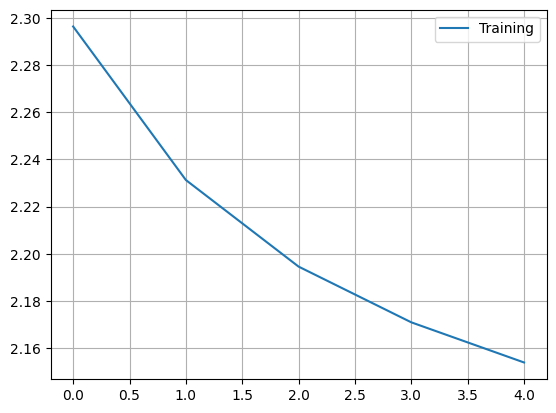

In [12]:
#training time
log = model.fit(X, y, epochs=5, batch_size=128)
plt.plot(log.history['loss'], label='Training')
plt.legend()
plt.grid()

In [18]:
def make_seed(seed_phrase=""):
        if seed_phrase:  # make sure the seed has the right length
            phrase_length = len(seed_phrase)
            pattern = ""
            for i in range (0, sentence_length):
                pattern += seed_phrase[i % phrase_length]
        else:            # sample randomly the seed from corpus
            seed = random.randint(0, corpus_length - sentence_length)
            pattern = corpus[seed:seed + sentence_length]
        return pattern

seed_pattern = make_seed("Smart syst")
print("seed = " + seed_pattern)

X = np.zeros((1, sentence_length, num_chars), dtype=float)
for i, character in enumerate(seed_pattern):
    X[0, i, encoding[character]] = 1

generated_text = ""
for i in range(500):
    output_prob = model.predict(X, verbose=0)[0]
    # in previous line predict() gives a tensor of shape (1, 65)
    # with 1 being the size of the batch, for that we use [0] to get a vector
    prediction = np.random.choice(num_chars, p = output_prob )
    generated_text += decoding[prediction]
    activations = np.zeros((1, 1, num_chars), dtype=bool)
    activations[0, 0, prediction] = 1
    #now remove first char and glue the predicted one
    X = np.concatenate((X[:, 1:, :], activations), axis=1)
print(generated_text)

seed = Smart syst
ems
Eg Intermating Condu
Enterserbee
Desstmow's
S.com
K Anergity
Clickitl
Fitnee
DosZee
Maghtort Gl
Dile IG
Pegrehtes
BusAos Rodgeal Camer
Eve Goop
Fig Media
ProHud Comporbore
Thk Paldon System
QiObHip
Smirger
PMC
Accapiua
Censestimp
Enginic Fatix Group
Latgen S. Imv.io
Frittial
Fusorragen
MariZem
QVF Medical Resbation
PGURR Ensertioss
InVide
Upili
Destes Internaty Spelinal
Sistata Dasing
Toletect
Kircor
Tractulo
7DAI-ta
BapeStulieal Apparg
SeNdy Plir
Sumerigh Crenty
Linkzo Dedics
Zenel Insigenc
